# Split 7:3

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [2]:
df = pd.read_csv('ELC.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,4347.826172,4527.950195,4347.826172,4409.937988,7790.0
1,2019-03-04,4409.937988,4527.950195,4322.981445,4347.826172,25064.0
2,2019-03-05,4409.937988,4409.937988,4335.403809,4347.826172,58956.0
3,2019-03-06,4347.826172,4372.670898,4347.826172,4347.826172,8434.0
4,2019-03-07,4366.459473,4440.993652,4335.403809,4335.403809,82027.0
...,...,...,...,...,...,...
1316,2024-06-10,27750.000000,27750.000000,27100.000000,27200.000000,1661200.0
1317,2024-06-11,27250.000000,28350.000000,27250.000000,28350.000000,2570200.0
1318,2024-06-12,28350.000000,28750.000000,27850.000000,28200.000000,1509300.0
1319,2024-06-13,28400.000000,29000.000000,27900.000000,28700.000000,3856900.0


In [4]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [5]:
df['time'] = pd.to_datetime(df['time'])

In [6]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1321 non-null   datetime64[ns]
 1   close   1321 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [7]:
df = df.set_index('time')

In [8]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

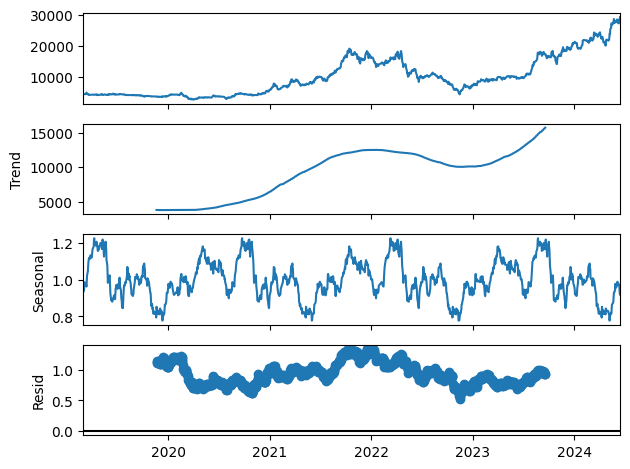

In [9]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [10]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [11]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [12]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=249, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


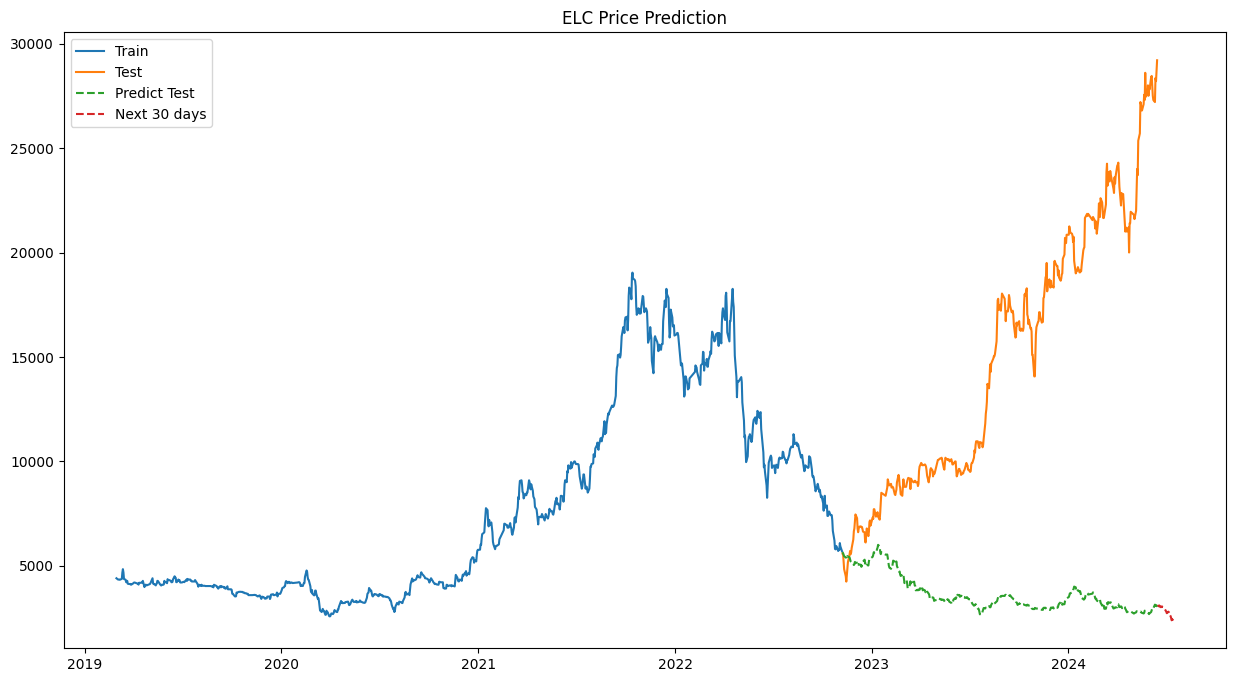

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index, train['close'], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [15]:
evaluateModel(test, pred)

** Testing **
MAE:  11306.117145507156
MAPE:  67.5826780842247
RMSE:  13310.905890458731
MSLE: 2.1688512426419737


In [16]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                  924
Model:             ExponentialSmoothing   SSE                       84060981.747
Optimized:                         True   AIC                          11058.547
Trend:                   Multiplicative   BIC                          12285.040
Seasonal:                Multiplicative   AICC                         11255.824
Seasonal Periods:                   249   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:46:34
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 8:2

In [17]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [18]:
df = pd.read_csv('ELC.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,4347.826172,4527.950195,4347.826172,4409.937988,7790.0
1,2019-03-04,4409.937988,4527.950195,4322.981445,4347.826172,25064.0
2,2019-03-05,4409.937988,4409.937988,4335.403809,4347.826172,58956.0
3,2019-03-06,4347.826172,4372.670898,4347.826172,4347.826172,8434.0
4,2019-03-07,4366.459473,4440.993652,4335.403809,4335.403809,82027.0
...,...,...,...,...,...,...
1316,2024-06-10,27750.000000,27750.000000,27100.000000,27200.000000,1661200.0
1317,2024-06-11,27250.000000,28350.000000,27250.000000,28350.000000,2570200.0
1318,2024-06-12,28350.000000,28750.000000,27850.000000,28200.000000,1509300.0
1319,2024-06-13,28400.000000,29000.000000,27900.000000,28700.000000,3856900.0


In [20]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [21]:
df['time'] = pd.to_datetime(df['time'])

In [22]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1321 non-null   datetime64[ns]
 1   close   1321 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [23]:
df = df.set_index('time')

In [24]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

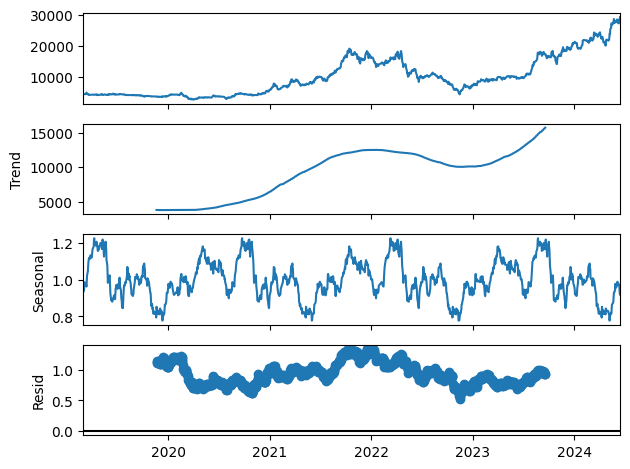

In [25]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [26]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [27]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [28]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=298, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


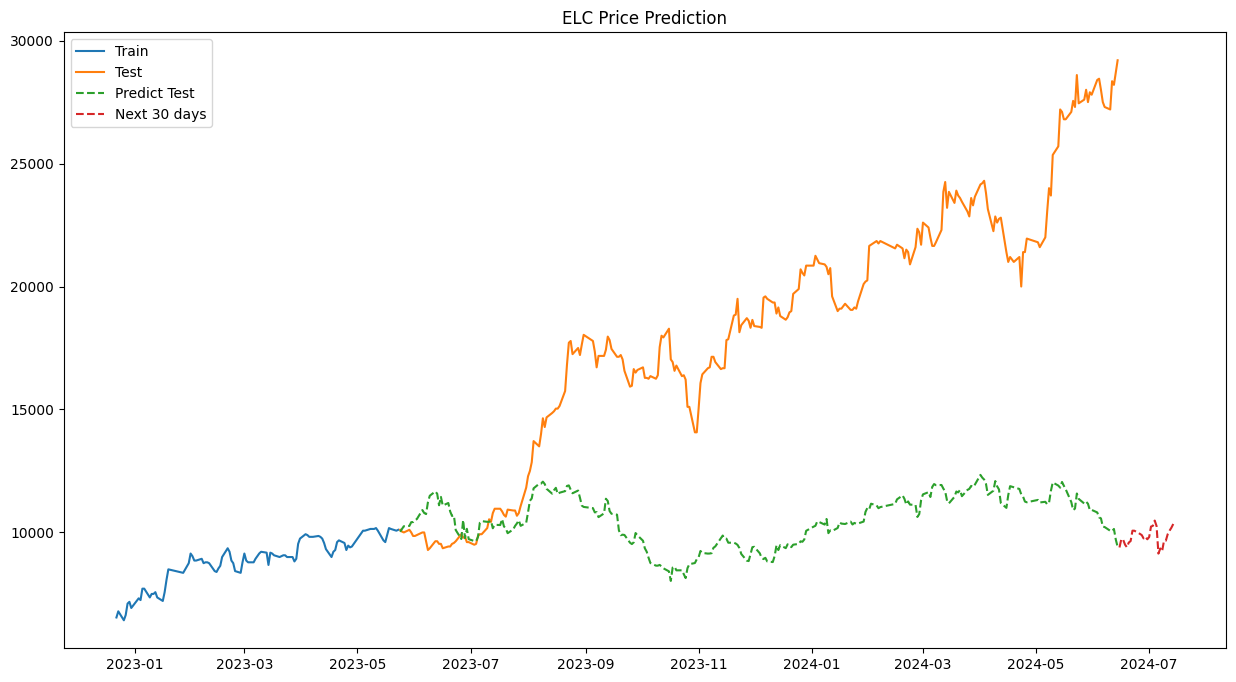

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [31]:
evaluateModel(test, pred)

** Testing **
MAE:  7999.361205366374
MAPE:  39.13572044839096
RMSE:  9292.519457478078
MSLE: 0.3596388256509686


In [32]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1056
Model:             ExponentialSmoothing   SSE                       59545343.351
Optimized:                         True   AIC                          12158.645
Trend:                   Multiplicative   BIC                          13662.205
Seasonal:                Multiplicative   AICC                         12407.525
Seasonal Periods:                   298   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:47:46
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 9:1

In [34]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [35]:
df = pd.read_csv('ELC.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,4347.826172,4527.950195,4347.826172,4409.937988,7790.0
1,2019-03-04,4409.937988,4527.950195,4322.981445,4347.826172,25064.0
2,2019-03-05,4409.937988,4409.937988,4335.403809,4347.826172,58956.0
3,2019-03-06,4347.826172,4372.670898,4347.826172,4347.826172,8434.0
4,2019-03-07,4366.459473,4440.993652,4335.403809,4335.403809,82027.0
...,...,...,...,...,...,...
1316,2024-06-10,27750.000000,27750.000000,27100.000000,27200.000000,1661200.0
1317,2024-06-11,27250.000000,28350.000000,27250.000000,28350.000000,2570200.0
1318,2024-06-12,28350.000000,28750.000000,27850.000000,28200.000000,1509300.0
1319,2024-06-13,28400.000000,29000.000000,27900.000000,28700.000000,3856900.0


In [37]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [39]:
df['time'] = pd.to_datetime(df['time'])

In [40]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1321 non-null   datetime64[ns]
 1   close   1321 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [41]:
df = df.set_index('time')

In [42]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

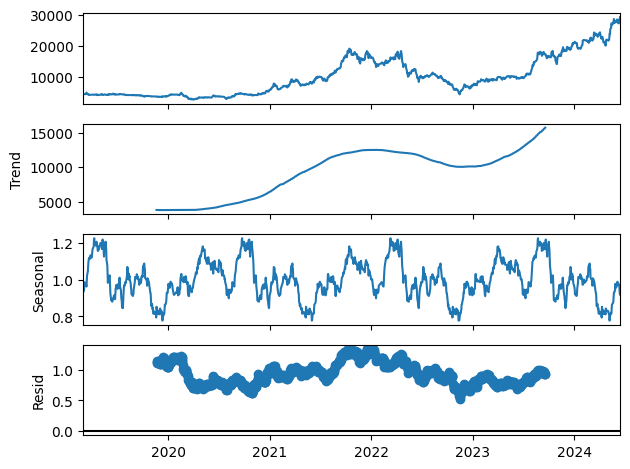

In [43]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [44]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [45]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

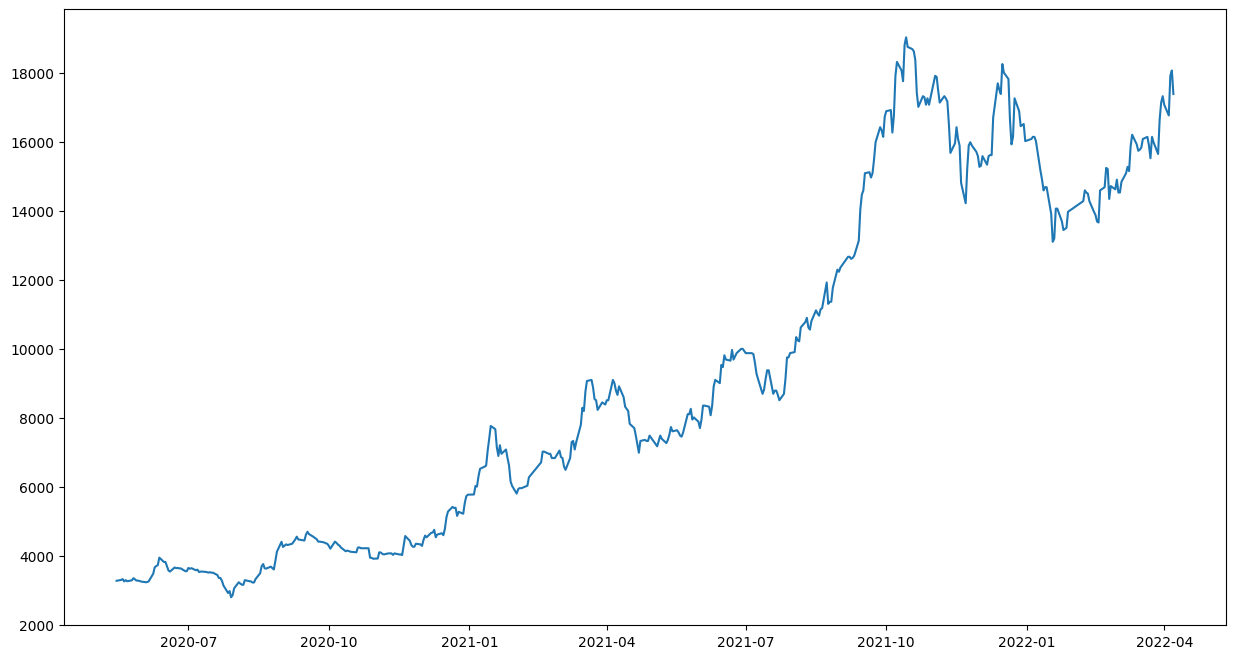

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['close'][300:777]);

In [47]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=348, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [48]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


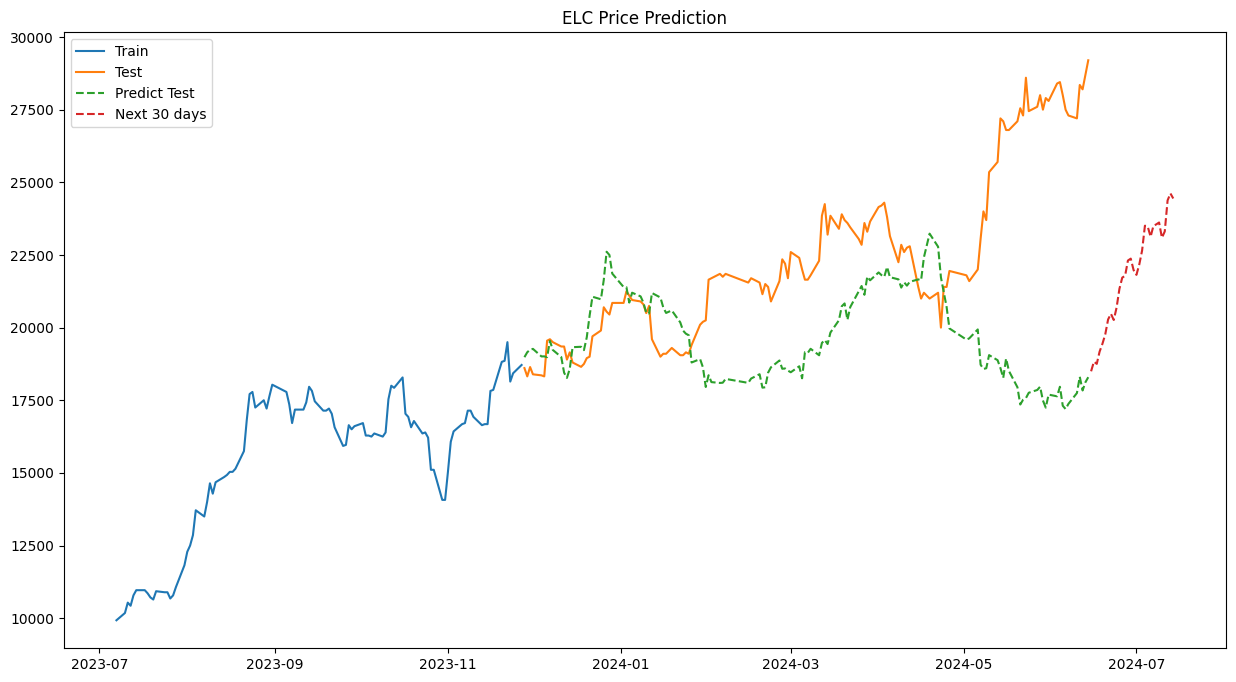

In [49]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [50]:
evaluateModel(test, pred)

** Testing **
MAE:  3408.128218535849
MAPE:  13.779782994386691
RMSE:  4767.017356941951
MSLE: 0.04660472278992249


In [51]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1188
Model:             ExponentialSmoothing   SSE                       93200953.297
Optimized:                         True   AIC                          14095.048
Trend:                   Multiplicative   BIC                          15888.297
Seasonal:                Multiplicative   AICC                         14398.846
Seasonal Periods:                   348   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:48:53
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       